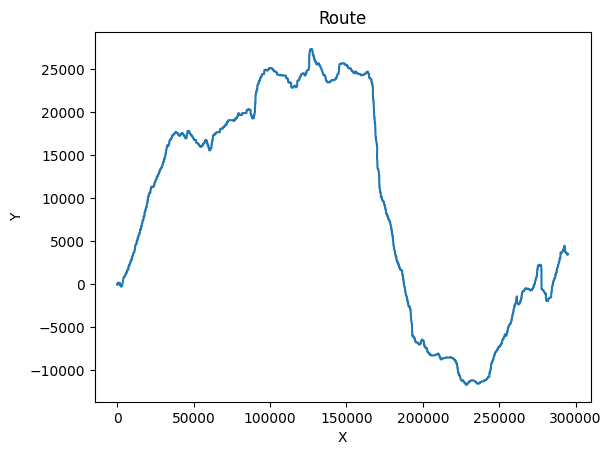

In [1]:
import numpy as np
import sys
sys.path.append('/path/to/directory')
import Predictionbicycle
import Objective
import Constraints
import casadi 
import Map
import matplotlib.pyplot as plt

In [2]:
#Actual route data
tabdata = Map.dumfunc()[0]
tabdata2 = Map.dumfunc()[1]

# Circular route for testing of radius 500m with centre (500,-500)
# tabdata = np.zeros((10000,2),dtype=float)
# tabdata2 = np.zeros(10000,dtype=float)
# for i in range(0,10000):
#     tabdata[i][0] = -500*np.cos(2*np.pi*i/10000)+500
#     tabdata[i][1] = 500*np.sin(2*np.pi*i/10000)-500
#     tabdata2[i] = np.pi/2-2*np.pi*i/10000

# S shape route for testing
# tabdata = np.zeros((10000,2),dtype=float)
# tabdata2 = np.zeros(10000,dtype=float)
# for i in range(0,5000):
#     tabdata[i][0] = 2*i
#     tabdata[i][1] = 0
#     tabdata2[i] = 0
# for i in range(5000,10000):
#     tabdata[i][0] = 10000-2*i
#     tabdata[i][1] = 2*(i-5000)
#     tabdata2[i] = np.pi/2-2*np.pi*(i-5000)/5000

#Sinusoidal route for testing
# tabdata = np.zeros((130,2),dtype=float)
# tabdata2 = np.zeros(130,dtype=float)
# for i in range(0,130):
#     tabdata[i][0] = i*100
#     tabdata[i][1] = 100*np.sin(i*np.pi/65)
#     tabdata2[i] = np.pi/2-i*np.pi/65

#Step shaped route for testing
# tabdata = np.zeros((10000,2),dtype=float)
# tabdata2 = np.zeros(10000,dtype=float)
# for i in range(0,10000):
#     if i%2==0:
#         tabdata[i][0]=5*i
#         tabdata[i][1]=1000-5*i
#         tabdata2[i]=0
#     else:
#         tabdata[i][0]=tabdata[i-1][0]+10
#         tabdata[i][1]=tabdata[i-1][1]
#         tabdata2[i]=np.pi/2

    
xlist = []
ylist = []
philist=[]
for i in range(len(tabdata)):
    xlist.append(tabdata[i][0])
    ylist.append(tabdata[i][1])

philist = tabdata2

#Platoon characteristics
N=4

# Vehicle parameters
m=1700
Cd=0.3
rho=1.225
Afront=2.2
Jvehicle=3000
a=1.5
b=1.5


#Reference velocities
xdotref=10
ydotref=10

vref=[xdotref,ydotref]
#Weights

wtrack=10 #Looks good
wangle =1 #Looks good
wv=5
wvr=0

wtor=10**(-10) # Seems perfect
wsteer=10**(-30) #Work on this

# Convert to list
parameters = [m,Afront,rho,Cd,Jvehicle,a,b]
weights= [wtrack,wangle,wv,wvr,wtor,wsteer]

#Limits
Fxfmin = -10000
Fxfmax = 0
Fxrmin = 0
Fxrmax = 10000
Fyfmin = -10000
Fyfmax = 0
Fyrmin = 0
Fyrmax = 10000

deltafmin = -100
deltafmax = 100
epsilonmin = 10
deltamin = 10


#MPC parameters
Np=5
Nc=3
Ts=1
Tsim= 100
Ntotal= int(Tsim/Ts)

#Main matrices
# u is the 5N x Np+1 matrix of control inputs --> to be optimized
# x0 is the 11N x 1 vector at time k =0
# cost is the total cost of the system till time k = Np
vehiclepoint = np.zeros(N,dtype=int)
vehiclepoint = [0,1,2,3]  # Which row of the Route.csv file is the vehicle at

x0=np.zeros((6*N,1),dtype=float)

#for i in range(0,N):
x0[0][0]= xlist[vehiclepoint[0]] #Initial X
x0[1][0]= ylist[vehiclepoint[0]] #Initial Y
x0[2][0]=10 #Initial xdot
x0[3][0]=10 #Initial ydot
x0[4][0]= philist[vehiclepoint[0]] #Initial phi
x0[5][0]=0  #Initial phidot

x0[6][0]= xlist[vehiclepoint[1]] #Initial X
x0[7][0]= ylist[vehiclepoint[1]] #Initial Y
x0[8][0]=15 #Initial xdot
x0[9][0]=15 #Initial ydot
x0[10][0]=philist[vehiclepoint[1]] #Initial phi
x0[11][0]=0  #Initial phidot

x0[12][0]= xlist[vehiclepoint[2]] #Initial X
x0[13][0]= ylist[vehiclepoint[2]] #Initial Y
x0[14][0]=30 #Initial xdot
x0[15][0]=30 #Initial ydot
x0[16][0]= philist[vehiclepoint[2]] #Initial phi
x0[17][0]=0  #Initial phidot

x0[18][0]= xlist[vehiclepoint[3]] #Initial X
x0[19][0]= ylist[vehiclepoint[3]] #Initial Y
x0[20][0]=30 #Initial xdot
x0[21][0]=30 #Initial ydot
x0[22][0]= philist[vehiclepoint[3]] #Initial phi
x0[23][0]=0  #Initial phidot

referencevector = np.zeros((3*N,1),dtype=float)
for i in range(0,N):
    referencevector[3*i][0]=xlist[vehiclepoint[i]]
    referencevector[3*i+1][0]=ylist[vehiclepoint[i]]
    referencevector[3*i+2][0]=philist[vehiclepoint[i]]

xhistory = np.zeros((6*N,Ntotal+1),dtype=float) # Except Xref,Yref

uhistory = np.zeros((5*N,Ntotal+1),dtype=float)


uhistory[0:5,0]=0
uhistory[5:10,0]=0
uhistory[10:15,0]=0


#Write the initial conditions into the history
for i in range(0,6*N):
    xhistory[i][0]=x0[i][0]

# Cost matrices
Q=np.zeros((9*N+2,9*N+2),dtype=float)
Q= Objective.Q(wvr,wv,wtrack,wangle,N)

R=np.zeros((5*N,5*N),dtype=float)
R= Objective.R(wtor,wsteer,N)

# Constraints
TMin= np.zeros((5*N,1),dtype=float)
TMin = Constraints.Tmin(Fxfmin,Fxrmin,Fyfmin,Fyrmin,deltafmin,N)

TMax= np.zeros((5*N,1),dtype=float)
TMax = Constraints.Tmax(Fxfmax,Fxrmax,Fyfmax,Fyrmax,deltafmax,N)

Cmin= np.zeros((2*N-2,1),dtype=float)
Cmin = Constraints.Cmin(epsilonmin,deltamin,N)

M= np.zeros((2*N-2,8*N),dtype=float)
M = Constraints.M(N)

Xlimit = np.zeros((N,1),dtype=float)
Ylimit = np.zeros((N,1),dtype=float)
for i in range(0,N):
    Xlimit[i] = epsilonmin
    Ylimit[i] = deltamin

   
opti=casadi.Opti()

Q_casadi = casadi.DM(Q)
R_casadi = casadi.DM(R)
TMin_casadi = casadi.DM(TMin)
TMax_casadi = casadi.DM(TMax)
Cmin_casadi = casadi.DM(Cmin)
M_casadi = casadi.DM(M)
Xlimit_casadi = casadi.DM(Xlimit)
Ylimit_casadi = casadi.DM(Ylimit)


for t in range(1,Ntotal+1):

    print("Iteration: ",t)

    u_casadi=opti.variable(5*N,Np) #From t=k to t=k+Np

    x_casadi=opti.variable(6*N,Np) #From t=k+1 to t=k+Np, except Xref,Yref..

    uex_casadi=opti.variable(5*N,Nc) #From t=k to t=k+Nc

    x0_casadi=opti.parameter(6*N,1) #At t=k

    # Warm start
    for i in range(0,6*N):
        opti.set_value(x0_casadi[i],xhistory[i][t-1])

    x_casadi[:,0]=Predictionbicycle.stepoverall(Ts,x0_casadi,N,uex_casadi[:,0],parameters)[:,0] # Stepping from t=k to t=k+1

    for i in range(1,Nc):
        x_casadi[:,i]=Predictionbicycle.stepoverall(Ts,x_casadi[:,i-1],N,uex_casadi[:,i],parameters)[:,0] 

    #Explicit MPC
    for i in range(Nc,Np):
        x_casadi[:,i]=Predictionbicycle.stepoverall(Ts,x_casadi[:,i-1],N,uex_casadi[:,Nc-1],parameters)[:,0] 
        
    for i in range(Nc,Np):
        u_casadi[:,i]=uex_casadi[:,Nc-1]

    # Change the reference vector
    for i in range(0,N):
        referencevector[3*i][0]=xlist[vehiclepoint[i]]
        referencevector[3*i+1][0]=ylist[vehiclepoint[i]]
        referencevector[3*i+2][0]=philist[vehiclepoint[i]]

    # Add the Xref,Yref into the x_casadi matrix
    xwithref_casadi = opti.variable(9*N+2,Np)
    for i in range(0,N):
        xwithref_casadi[9*i] = x_casadi[6*i]
        xwithref_casadi[9*i+1] = x_casadi[6*i+1]
        xwithref_casadi[9*i+2] = x_casadi[6*i+2]
        xwithref_casadi[9*i+3] = x_casadi[6*i+3]
        xwithref_casadi[9*i+4] = x_casadi[6*i+4]
        xwithref_casadi[9*i+5] = x_casadi[6*i+5]
        xwithref_casadi[9*i+6] = referencevector[3*i]
        xwithref_casadi[9*i+7] = referencevector[3*i+1]
        xwithref_casadi[9*i+8] = referencevector[3*i+2]

    xwithref_casadi[9*N] =vref[0]
    xwithref_casadi[9*N+1] =vref[1]

    #Cost function
    cost=0
    for i in range(0,Np):
        cost=cost+(xwithref_casadi[:,i]).T@Q_casadi@xwithref_casadi[:,i]+(u_casadi[:,i]).T@R_casadi@u_casadi[:,i]
    
    opti.minimize(cost)

    #Set initial value of all inputs as zero for fast computation
    for i in range(0,Np):
        opti.set_initial(u_casadi[:,i],uhistory[:,t-1]+1)
        #opti.set_initial(u_casadi[:,i],0)
         
    #Set initial value of all states as the previous value

    
    checkXmatrix = casadi.MX.zeros(N,1)
    checkYmatrix = casadi.MX.zeros(N,1)
    checkxdotmaatrix = casadi.MX.zeros(N,1)
    checkydotmatrix = casadi.MX.zeros(N,1)


    for i in range(0,N):
        checkXmatrix[i]=xwithref_casadi[9*i,0]-xwithref_casadi[9*i+6,0]
        checkYmatrix[i]=xwithref_casadi[9*i+1,0]-xwithref_casadi[9*i+7,0]


    for i in range(0,N):
        checkxdotmaatrix[i]=xwithref_casadi[9*i+2,0]
        checkydotmatrix[i]=xwithref_casadi[9*i+3,0]


    for i in range(0,Np):
        print("Iteration of constraint: ",i)
        opti.subject_to(TMin_casadi<=u_casadi[:,i])
        opti.subject_to(TMax_casadi>=u_casadi[:,i])
        #opti.subject_to(checkXmatrix<=Xlimit_casadi)
        #opti.subject_to(checkYmatrix<=Ylimit_casadi)
        opti.subject_to(checkxdotmaatrix<=50)
        opti.subject_to(checkydotmatrix<=50)
        opti.subject_to(checkxdotmaatrix>=-50)
        opti.subject_to(checkydotmatrix>=-50)
        #opti.subject_to(M_casadi@x_casadi[:,i]>=Cmin_casadi)
        #opti.subject_to(check1matrix==0)
        #opti.subject_to(check2matrix==0)

    #Constraint that the velocities must always be positive
    #for i in range(0,Np):
     #   for j in range(0,N):
      #      opti.subject_to(x_casadi[9*j+2,i]>0)
       #     opti.subject_to(x_casadi[9*j+3,i]>0)

    solver_opts = {"ipopt": {"print_level": 0, "linear_solver": "mumps"}}
    opti.solver('ipopt', solver_opts)

    print("Solving...")
    sol = opti.solve()

   
    print("xwithrefcasadi: ")
    print(sol.value(xwithref_casadi)) #11N x Np
    print("ucasadi: ")
    print(sol.value(u_casadi)) #5N x Np
    print("cost: ")
    print(sol.value(cost))
    
    #Update platoon target to next row
    for i in range(0,N):
        vehiclepoint[i]+=1
   
    print("vehiclepoint: ",vehiclepoint)
    # Update into the history
    for i in range(0,N):
        xhistory[6*i][t]=sol.value(xwithref_casadi[9*i])
        xhistory[6*i+1][t]=sol.value(xwithref_casadi[9*i+1])
        xhistory[6*i+2][t]=sol.value(xwithref_casadi[9*i+2])
        xhistory[6*i+3][t]=sol.value(xwithref_casadi[9*i+3])
        xhistory[6*i+4][t]=sol.value(xwithref_casadi[9*i+4])
        xhistory[6*i+5][t]=sol.value(xwithref_casadi[9*i+5])
    

    for i in range(0,N):
        uhistory[5*i][t]=sol.value(u_casadi[5*i])
        uhistory[5*i+1][t]=sol.value(u_casadi[5*i+1])
        uhistory[5*i+2][t]=sol.value(u_casadi[5*i+2])
        uhistory[5*i+3][t]=sol.value(u_casadi[5*i+3])
        uhistory[5*i+4][t]=sol.value(u_casadi[5*i+4])

    print("iteration: ",t," completed")


Iteration:  1
Iteration of constraint:  0
Iteration of constraint:  1
Iteration of constraint:  2
Iteration of constraint:  3
Iteration of constraint:  4
Solving...

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |  15.00ms (326.09us)  18.86ms (410.11us)        46
       nlp_g  |  33.00ms (717.39us)  14.57ms (316.78us)        46
  nlp_grad_f  |  26.00ms (553.19us)  45.68ms (971.98us)        47
  nlp_hess_l  |   2.03 s ( 45.18ms)   2.01 s ( 44.57ms)        45
   nlp_jac_g  |  64.00ms (  1.36ms)  70.11ms (  1.49ms)        47
       total  |   2.79 s (  2.79 s)   2.79 s (  2.79

: 

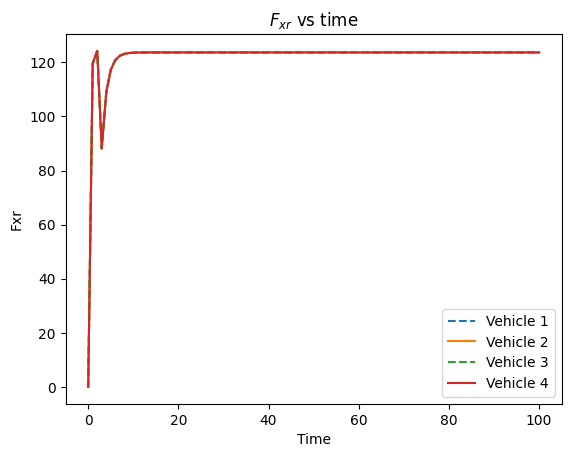

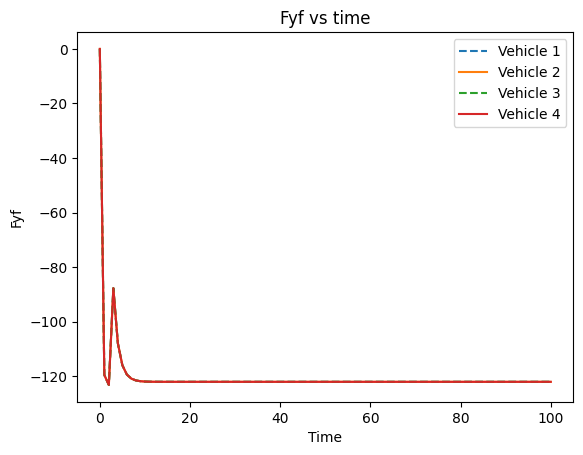

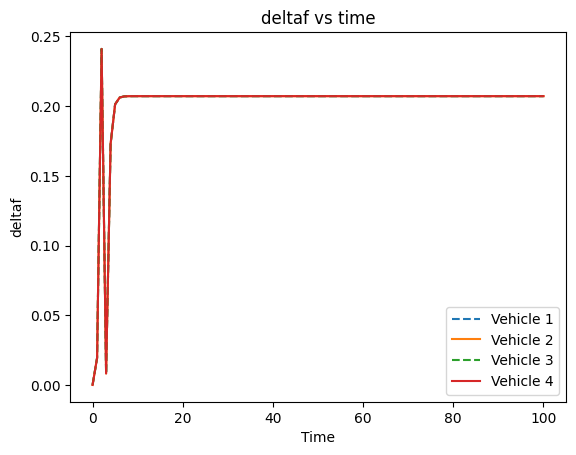

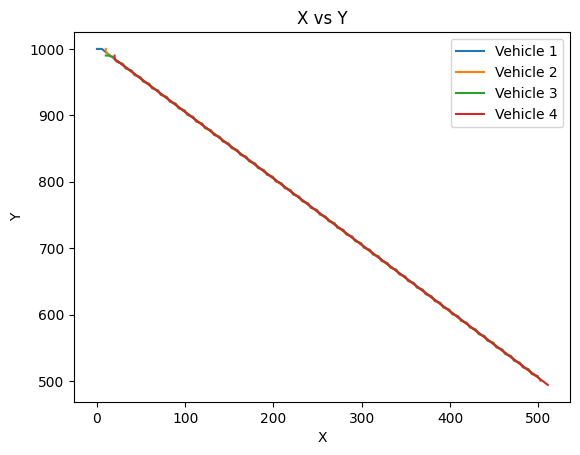

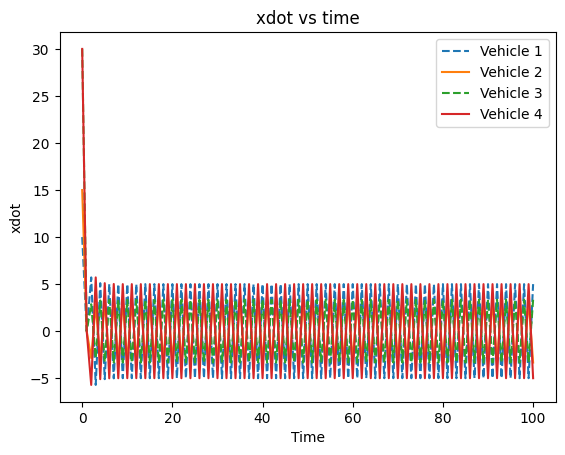

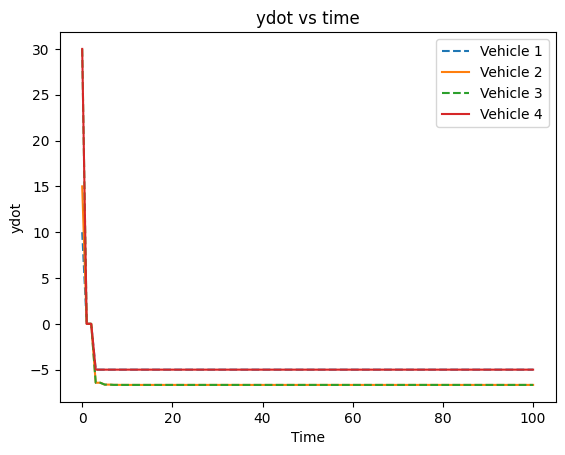

Max deviation for vehicle  0  is  10.879675865520035
Max deviation for vehicle  1  is  10.0
Max deviation for vehicle  2  is  14.142135623730951
Max deviation for vehicle  3  is  22.360679774997898


In [ ]:

# Latex Plotting

#Export tabdata as in 1 .csv
np.savetxt('tabdata.csv', tabdata, delimiter=',')
np.savetxt('tabdata2.csv', tabdata2, delimiter=',')

#1. Plot of input 2 (Fxr) vs time for all vehicles with legend
plt.figure(1)
plt.plot(uhistory[1],'--')
plt.plot(uhistory[6])
plt.plot(uhistory[11],'--')
plt.plot(uhistory[16])
plt.title('$F_{xr}$ vs time')
plt.xlabel('Time')
plt.ylabel('Fxr')
plt.legend(['Vehicle 1','Vehicle 2','Vehicle 3','Vehicle 4'])
plt.show()

#2. Plot of input 3 (Fyf) vs time for all vehicles with legend
plt.figure(2)
plt.plot(uhistory[2],'--')
plt.plot(uhistory[7])
plt.plot(uhistory[12], '--')
plt.plot(uhistory[17])
plt.title('Fyf vs time')
plt.xlabel('Time')
plt.ylabel('Fyf')
plt.legend(['Vehicle 1','Vehicle 2','Vehicle 3','Vehicle 4'])
plt.show()

#3. Plot of deltaf vs time for all vehicles with legend
plt.figure(3)
plt.plot(uhistory[4],'--')
plt.plot(uhistory[9])
plt.plot(uhistory[14],'--')
plt.plot(uhistory[19])
plt.title('deltaf vs time')
plt.xlabel('Time')
plt.ylabel('deltaf')
plt.legend(['Vehicle 1','Vehicle 2','Vehicle 3','Vehicle 4'])
plt.show()

#4. Plot of X vs Y for all vehicles with legend and reference trajectory
plt.figure(4)
plt.plot(xhistory[0],xhistory[1])
plt.plot(xhistory[6],xhistory[7])
plt.plot(xhistory[12],xhistory[13])
plt.plot(xhistory[18],xhistory[19])
#plt.plot(xlist[0:Ntotal],ylist[0:Ntotal],'--')
plt.title('X vs Y')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend(['Vehicle 1','Vehicle 2','Vehicle 3','Vehicle 4','Reference trajectory'])
plt.show()

#Save as .csv
np.savetxt('xhistory.csv', xhistory, delimiter=',')

#5. Plot of xdot vs time for all vehicles with legend 
plt.figure(5)
plt.plot(xhistory[2], '--')
plt.plot(xhistory[8])
plt.plot(xhistory[14], '--')
plt.plot(xhistory[20])
plt.title('xdot vs time')
plt.xlabel('Time')
plt.ylabel('xdot')
plt.legend(['Vehicle 1','Vehicle 2','Vehicle 3','Vehicle 4'])
plt.show()


#6. Plot of ydot vs time for all vehicles with legend
plt.figure(6)
plt.plot(xhistory[3], '--')
plt.plot(xhistory[9])
plt.plot(xhistory[15], '--')
plt.plot(xhistory[21])
plt.title('ydot vs time')
plt.xlabel('Time')
plt.ylabel('ydot')
plt.legend(['Vehicle 1','Vehicle 2','Vehicle 3','Vehicle 4'])
plt.show()


# Max deviation from route
maxdeviation = np.zeros(N,dtype=float)
for i in range(0,N):
    for j in range(0,Ntotal):
        if maxdeviation[i]<np.sqrt((xhistory[6*i][j]-xlist[j])**2+(xhistory[6*i+1][j]-ylist[j])**2):
            maxdeviation[i]=np.sqrt((xhistory[6*i][j]-xlist[j])**2+(xhistory[6*i+1][j]-ylist[j])**2)

    print("Max deviation for vehicle ",i," is ",maxdeviation[i])




